In [1]:
import yfinance
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters

In [2]:
# load data
ticket = yfinance.Ticker("MSFT")

start_date = datetime.datetime(2021, 1, 11)
end_date = datetime.datetime(2022, 12, 20)

history_prices = ticket.history(start=start_date, end=end_date)

# print(history_prices)
# print(history_prices.shape)

In [3]:
# Select columns
data_clean = history_prices[["Open", "High", "Low", "Close", "Volume"]]
data_clean_ext = data_clean.copy()

# Convert all columns to float
data_clean['Volume'] = data_clean['Volume'].astype(float)
data_clean_ext['Volume'] = data_clean_ext['Volume'].astype(float)

n_features = data_clean.shape[1]

# Convert the data to numpy values
np_data_unscaled = np.array(data_clean)
# print(np_data_unscaled)

<ipython-input-3-338ac09cd281>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Volume'] = data_clean['Volume'].astype(float)


In [4]:
# Transform the data by scaling each feature to a range between 0 and 1???why this scaler
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
# print(np_data_scaled)

In [5]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_close_prices = pd.DataFrame(data_clean_ext[["Open", "High", "Low", "Close", "Volume"]])
np_prices_scaled = scaler_pred.fit_transform(df_close_prices)
# print(np_prices_scaled)

In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
n_steps_in = 5    # 5 days
n_steps_out = 10   # 10 days

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 75% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.75)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - n_steps_in:, :]

# split a multivariate sequence into samples
def split_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Generate training data and test data
x_train, y_train = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(354, 5, 5)
(113, 5, 5)
(354, 10, 5)
(113, 10, 5)


In [ ]:
def build_model(hp):
    
    model = Sequential()
    
    # number of dense layer
    dense = hp.Int("n_dense",
                  min_value=0,
                  max_value=3)

    # first LSTM-layer
    model.add(LSTM(units=hp.Int("n_units1",
                               min_value=32,
                               max_value=512,
                               step=16),
                  input_shape=(n_steps_in, n_features)))
    
    model.add(RepeatVector(n_steps_out))
    
    # add dense layers
    if dense > 0:
        for layer in range(dense):
            model.add(Dropout(hp.Float("v_dropout_dense" + str(layer + 1),
                                      min_value = 0.05,
                                      max_value = 0.2,
                                      step = 0.05)))
            model.add(Dense(units=hp.Int("n_units_dense" + str(layer + 1),
                                        min_value = 32,
                                        max_value = 512,
                                        step = 16),
                           activation=hp.Choice("v_activation_dense",
                                               values=["relu", "tanh", "sigmoid"],
                                               default="relu")))
            
    model.add(Dropout(hp.Float("v_dropout",
                              min_value=0.05,
                              max_value=0.2,
                              step=0.05)))
    
    model.add(LSTM(units=hp.Int("n_units2",
                               min_value=32,
                               max_value=256,
                               step=16),
                  return_sequences = True))

    model.add(TimeDistributed(Dense(n_features)))

    model.compile(optimizer = "adam",
                 loss = "mean_absolute_error"
                 )
    
    return model

In [ ]:
tuner = RandomSearch(build_model,
                     objective="val_loss",
                     max_trials=10,
                     seed=9999,
                     executions_per_trial=50,
                     directory="",
                     project_name="RandomSearch_Multistep_NoSentiment")

early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)

tuner.search(x_train, 
            y_train, 
            epochs=500, 
            batch_size=16, 
            validation_split=0.25,
            callbacks=[early_stopping_cb],
            verbose = 1)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# save best model for that variable combination
best_model.save("best_model_multistep_nosentiment.h5")

# Evaluate the best model with test data
loss = best_model.evaluate(x_test, y_test)

In [ ]:
model = load_model("best_model_multistep_nosentiment.h5")
model.summary()
#model.get_config()

In [8]:
# Configure the neural network model
model = Sequential()
model.add(LSTM(336, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(RepeatVector(n_steps_out))
model.add(Dropout(0.1))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.05))
model.add(LSTM(80, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(TimeDistributed(Dense(n_features)))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 336)               459648    
                                                                 
 repeat_vector (RepeatVector  (None, 10, 336)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 336)           0         
                                                                 
 dense (Dense)               (None, 10, 256)           86272     
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 80)            107840    
                                                        

In [9]:
# Check-points and early stopping parameters make our modeling easier
# Specfy the file and file path for the best model
checkpoint_path = 'D:/COLLEGE/COMPS/best_model_multistep_nosentiment.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=0)
callbacks = [checkpoint, earlystopping]

# Training the model
epochs = 500
batch_size = 32
history = model.fit(x_train, y_train,
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(x_test, y_test),
                     callbacks = callbacks,
                     verbose = 0)

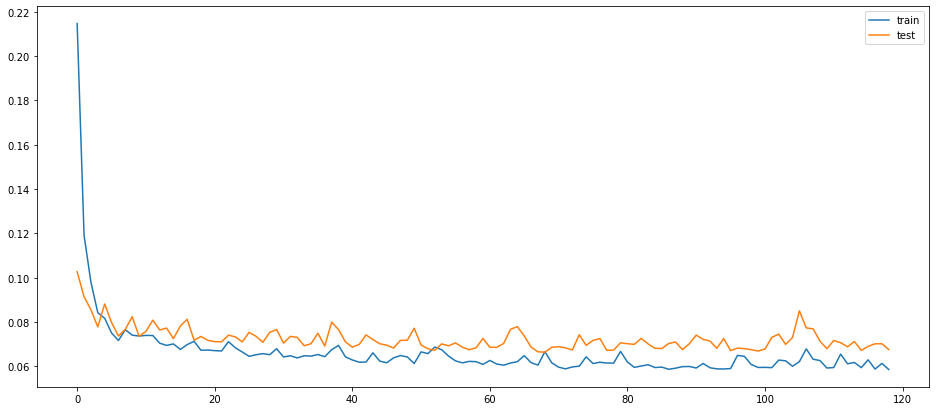

In [10]:
# Load the best model
model_from_saved_checkpoint = load_model(checkpoint_path)

# Plot training & validation loss values
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
# Get the predicted values
y_pred_scaled = model_from_saved_checkpoint.predict(x_test)

# inverse data transform on forecasts
def inverse_transform(forecasts, scaler):
    inverted = []
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # store
        inverted.append(inv_scale)
    return inverted

y_pred = inverse_transform(y_pred_scaled, scaler_pred)
y_test_unscaled = inverse_transform(y_test, scaler_pred)

In [12]:
# Store prediction values in dataframes
y_pred_df = pd.DataFrame(y_pred, columns=["Open", "High", "Low", "Close", "Volume"])
y_test_unscaled_df = pd.DataFrame(y_test_unscaled, columns=["Open", "High", "Low", "Close", "Volume"])

In [13]:
def forecast_accuracy(forecast, actual):
    mse = np.square(np.subtract(actual, forecast)).mean()     # MSE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mse': mse, 'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
    
print('Forecast Accuracy of: Open')
accuracy_prod = forecast_accuracy(y_pred_df['Open'].values, y_test_unscaled_df['Open'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: High')
accuracy_prod = forecast_accuracy(y_pred_df['High'].values, y_test_unscaled_df['High'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: Low')
accuracy_prod = forecast_accuracy(y_pred_df['Low'].values, y_test_unscaled_df['Low'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(y_pred_df['Close'].values, y_test_unscaled_df['Close'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: Volume')
accuracy_prod = forecast_accuracy(y_pred_df['Volume'].values, y_test_unscaled_df['Volume'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Open
mse :  26.2686
mape :  0.017
me :  -3.2716
mae :  4.3247
mpe :  -0.0124
rmse :  5.1253
corr :  0.9786
minmax :  0.0169
Forecast Accuracy of: High
mse :  38.6215
mape :  0.0201
me :  -4.3307
mae :  5.1785
mpe :  -0.0165
rmse :  6.2146
corr :  0.9686
minmax :  0.0201
Forecast Accuracy of: Low
mse :  24.887
mape :  0.0161
me :  -2.1976
mae :  4.0267
mpe :  -0.0083
rmse :  4.9887
corr :  0.971
minmax :  0.016
Forecast Accuracy of: Close
mse :  44.9536
mape :  0.021
me :  -3.2666
mae :  5.3169
mpe :  -0.0124
rmse :  6.7047
corr :  0.948
minmax :  0.0209
Forecast Accuracy of: Volume
mse :  70959573099290.58
mape :  0.176
me :  -2014509.3628
mae :  5105354.0708
mpe :  -0.0081
rmse :  8423750.5364
corr :  0.3984
minmax :  0.1562


In [14]:
# only get the close prices
y_test_unscaled_close = [item[3] for item in y_test_unscaled]
y_pred_close = [item[3] for item in y_pred]

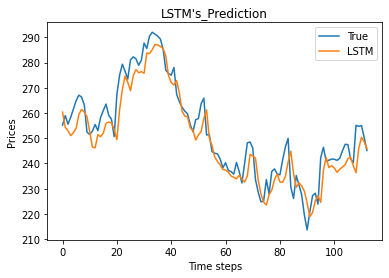

In [15]:
# Plot of the true and predicted case counts
plt.plot(y_test_unscaled_close, label='True')
plt.plot(y_pred_close, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Time steps')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [16]:
# predict 30 days ahead

n_times_ahead = 3
look_back_df = data_clean.copy()
all_price_pred = []

for i in range(n_times_ahead):
    # New data frame for predicting the next day price
    new_df = look_back_df[-n_steps_in:][["Open", "High", "Low", "Close", "Volume"]]

    # Get the values of the last N day prices 
    # scale the data to be values between 0 and 1
    last_N_days = new_df[-n_steps_in:][["Open", "High", "Low", "Close", "Volume"]]
    last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_prices_scaled = model_from_saved_checkpoint.predict(np.array(X_test_new))

    # Unscale data
    for i in range(len(pred_prices_scaled[0])):
        pred_prices_unscaled = scaler_pred.inverse_transform([pred_prices_scaled[0][i]])
        all_price_pred.append(pred_prices_unscaled[0])
        
        # Add predicted data into the dataframe
        look_back_df.loc[len(look_back_df.index)] = pred_prices_unscaled[0]

D:\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


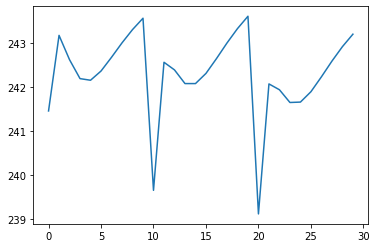

In [17]:
# Plot of predictions
close_price_pred = [items[3] for items in all_price_pred]
plt.plot(close_price_pred)

In [18]:
# load actual price data
ticket = yfinance.Ticker("MSFT")

start_date_pred = datetime.datetime(2022, 12, 20)
end_date_pred = datetime.datetime(2023, 2, 3)

actual_prices = ticket.history(start=start_date_pred, end=end_date_pred)
actual_prices = actual_prices[["Close"]]

# print(actual_prices)
# print(actual_prices.shape)

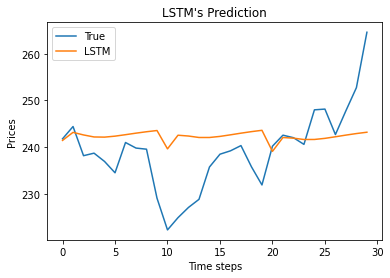

In [19]:
close_price_actual = actual_prices["Close"].values.tolist()

# plot predictions vs. actual
plt.plot(close_price_actual, label='True')
plt.plot(close_price_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Time steps')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [20]:
# inverse data transform on forecasts
def inverse_transform2(forecasts, scaler):
    inverted = []
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        # invert scale everything when it is the last set
        # extract the first row when it is not the last set
        if i == len(forecasts)-1:
            for j in range(len(inv_scale)):
                inverted.append(inv_scale[j])
        else:
            inv_scale = inv_scale[0, :]
            # store
            inverted.append(inv_scale)
    return inverted

In [21]:
# clean up results

# Unscale the training data
y_train_unscaled = inverse_transform2(y_train, scaler_pred)
y_train_unscaled_close = [items[3] for items in y_train_unscaled]

# Get predicted training data
y_pred_scaled_train = model_from_saved_checkpoint.predict(x_train)

# Unscale the predicted training data
y_pred_train = inverse_transform2(y_pred_scaled_train, scaler_pred)
y_pred_train_close = [items[3] for items in y_pred_train]

# Unscale the testing data 
y_test_unscaled2 = inverse_transform2(y_test, scaler_pred)
y_test_unscaled_close2 = [items[3] for items in y_test_unscaled2]

# Unscale the predicted testing data
y_pred_close2 = inverse_transform2(y_pred_scaled, scaler_pred)
y_pred_close2_close = [items[3] for items in y_pred_close2]

# combine all true stock prices
true_unscaled = np.concatenate((y_train_unscaled_close, y_test_unscaled_close2)).tolist()

# combine all predicted stock prices
predicted_unscaled = np.concatenate((y_pred_train_close, y_pred_close2_close)).tolist()

In [22]:
# create date column
history_prices_index = history_prices.index.tolist()
history_prices_dates = [str(date.date()) for date in history_prices_index]
actual_prices_index = actual_prices.index.tolist()
actual_prices_dates = [str(date.date()) for date in actual_prices_index]

In [23]:
# merge results into a dataframe
results = {
    "Date": history_prices_dates[5:] + actual_prices_dates,
    "True": true_unscaled + close_price_actual,
    "LSTM": predicted_unscaled + close_price_pred
}
results_df = pd.DataFrame(data=results)
results_df = results_df.set_index("Date")

In [ ]:
results_df

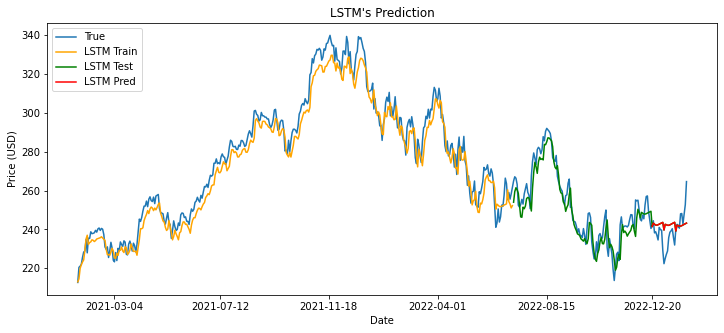

In [24]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Plot of the true and predicted prices
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(results_df['True'], label='True')
ax.plot(results_df['LSTM'][0:train_data_len], label='LSTM Train', color = 'orange')
ax.plot(results_df['LSTM'][train_data_len:], label='LSTM Test', color = 'green')
ax.plot(results_df['LSTM'][-30:], label='LSTM Pred', color = 'red')

# Format dates on x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.title("LSTM's Prediction")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('results_multivariate_nosentiment.jpg', bbox_inches='tight', dpi=300)
# plt.close()

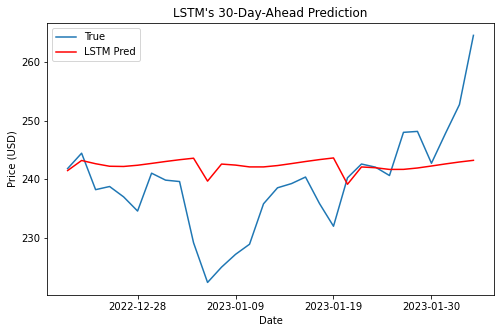

In [25]:
# Zoomed-in plot of predicted prices
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(results_df['True'][-30:], label='True')
ax.plot(results_df['LSTM'][-30:], label='LSTM Pred', color = 'red')

# Format dates on x-axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

plt.title("LSTM's 30-Day-Ahead Prediction")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('results_multivariate_nosentiment_30.jpg', bbox_inches='tight', dpi=300)
# plt.close()

In [ ]:
# only compare the most recent 20 days of predictions
close_price_pred = close_price_pred[-20:]
close_price_actual = close_price_actual[-20:]

In [26]:
# prediction metrics 

# MSE
MSE = mean_squared_error(close_price_actual, close_price_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# RMSE
RMSE = math.sqrt(mean_squared_error(close_price_actual, close_price_pred))
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(close_price_actual, close_price_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Squared Error (MSE): 76.95
Root Mean Squared Error (RMSE): 8.77
Mean Absolute Error (MAE): 6.56
Mean Absolute Percentage Error (MAPE): 2.77 %
Median Absolute Percentage Error (MDAPE): 1.98 %


In [ ]:
# run models multiple times to calculate errors
MSEs_30 = []
MAEs_30 = []
MAPEs_30 = []
MSEs_20 = []
MAEs_20 = []
MAPEs_20 = []

for _ in range(10):
    model = Sequential()
    model.add(LSTM(336, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(RepeatVector(n_steps_out))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.05))
    model.add(LSTM(80, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(TimeDistributed(Dense(n_features)))

    # Compiling the LSTM
    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    checkpoint_path = 'D:/COLLEGE/COMPS/best_model_multistep_nosentiment.hdf5'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                 monitor='val_loss',
                                 verbose=0, 
                                 save_best_only=True,
                                 mode='min')

    earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=0)
    callbacks = [checkpoint, earlystopping]

    # Training the model
    epochs = 500
    batch_size = 32
    history = model.fit(x_train, y_train,
                         batch_size=batch_size, 
                         epochs=epochs,
                         validation_data=(x_test, y_test),
                         callbacks = callbacks,
                         verbose = 0)

    model_from_saved_checkpoint = load_model(checkpoint_path)

    # Get the predicted values
    y_pred_scaled = model_from_saved_checkpoint.predict(x_test)
    y_pred = inverse_transform(y_pred_scaled, scaler_pred)
    y_test_unscaled = inverse_transform(y_test, scaler_pred)

    # Store prediction values in dataframes
    y_pred_df = pd.DataFrame(y_pred, columns=["Open", "High", "Low", "Close", "Volume"])
    y_test_unscaled_df = pd.DataFrame(y_test_unscaled, columns=["Open", "High", "Low", "Close", "Volume"])

    # only get the close prices
    y_test_unscaled_close = [item[3] for item in y_test_unscaled]
    y_pred_close = [item[3] for item in y_pred]

    # predict 30 days ahead

    n_times_ahead = 3
    look_back_df = data_clean.copy()
    all_price_pred = []

    for i in range(n_times_ahead):
        # New data frame for predicting the next day price
        new_df = look_back_df[-n_steps_in:][["Open", "High", "Low", "Close", "Volume"]]

        # Get the values of the last N day prices 
        # scale the data to be values between 0 and 1
        last_N_days = new_df[-n_steps_in:][["Open", "High", "Low", "Close", "Volume"]]
        last_N_days_scaled = scaler.transform(last_N_days)

        # Create an empty list and Append past N days
        X_test_new = []
        X_test_new.append(last_N_days_scaled)

        # Convert the X_test data set to a numpy array and reshape the data
        pred_prices_scaled = model_from_saved_checkpoint.predict(np.array(X_test_new))

        # Unscale data
        for i in range(len(pred_prices_scaled[0])):
            pred_prices_unscaled = scaler_pred.inverse_transform([pred_prices_scaled[0][i]])
            all_price_pred.append(pred_prices_unscaled[0])

            # Add predicted data into the dataframe
            look_back_df.loc[len(look_back_df.index)] = pred_prices_unscaled[0]

    close_price_pred = [items[3] for items in all_price_pred]
    close_price_actual = actual_prices["Close"].values.tolist()

    MSE = mean_squared_error(close_price_actual, close_price_pred)
    MAE = mean_absolute_error(close_price_actual, close_price_pred)
    MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100

    MSEs_30.append(MSE)
    MAEs_30.append(MAE)
    MAPEs_30.append(MAPE)

    # only compare the most recent 20 days of predictions
    close_price_pred = close_price_pred[-20:]
    close_price_actual = close_price_actual[-20:]

    MSE = mean_squared_error(close_price_actual, close_price_pred)
    MAE = mean_absolute_error(close_price_actual, close_price_pred)
    MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100

    MSEs_20.append(MSE)
    MAEs_20.append(MAE)
    MAPEs_20.append(MAPE)

In [ ]:
print(len(MSEs_30))
print(len(MAEs_30))
print(len(MAPEs_30))
print(len(MSEs_20))
print(len(MAEs_20))
print(len(MAPEs_20))

print(MSEs_30)
print(MAEs_30)
print(MAPEs_30)
print(MSEs_20)
print(MAEs_20)
print(MAPEs_20)

In [ ]:
print(sum(MSEs_30)/len(MSEs_30))
print(sum(MAEs_30)/len(MAEs_30))
print(sum(MAPEs_30)/len(MAPEs_30))
print()
print(sum(MSEs_20)/len(MSEs_20))
print(sum(MAEs_20)/len(MAEs_20))
print(sum(MAPEs_20)/len(MAPEs_20))